# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("azdias dataset shape: ", azdias.shape) 
#the first element in the shape is the number of rows and the second element is the number of columns
print('Features dataset shape: ', feat_info.shape)

azdias dataset shape:  (891221, 85)
Features dataset shape:  (85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_ANTG4,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum()[azdias.isnull().sum()!=0].sort_values(ascending =False).reset_index()

,index,0
0,KK_KUNDENTYP,584612
1,KBA05_ANTG3,133324
2,KBA05_ANTG2,133324
3,KBA05_ANTG4,133324
4,KBA05_BAUMAX,133324
5,KBA05_GBZ,133324
6,KBA05_ANTG1,133324
7,MOBI_REGIO,133324
8,KKK,121196
9,REGIOTYP,121196


In [10]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))

In [11]:
type(feat_info['missing_or_unknown'])

pandas.core.series.Series

In [12]:
count =0
for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_or_unknown[0] != '':
        for value in missing_or_unknown:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                azdias.loc[azdias[attribute] == int(value), attribute] = np.nan
            else:
                    azdias.loc[azdias[attribute] == value, attribute] = np.nan

In [13]:
print("azdias dataset shape: ", azdias.shape)
azdias.head()

azdias dataset shape:  (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing = azdias.isnull().sum()
missing[missing!=0].sort_values(ascending=False).reset_index()

,index,0
0,TITEL_KZ,889061
1,AGER_TYP,685843
2,KK_KUNDENTYP,584612
3,KBA05_BAUMAX,476524
4,GEBURTSJAHR,392318
5,ALTER_HH,310267
6,REGIOTYP,158064
7,KKK,158064
8,W_KEIT_KIND_HH,147988
9,KBA05_ANTG4,133324


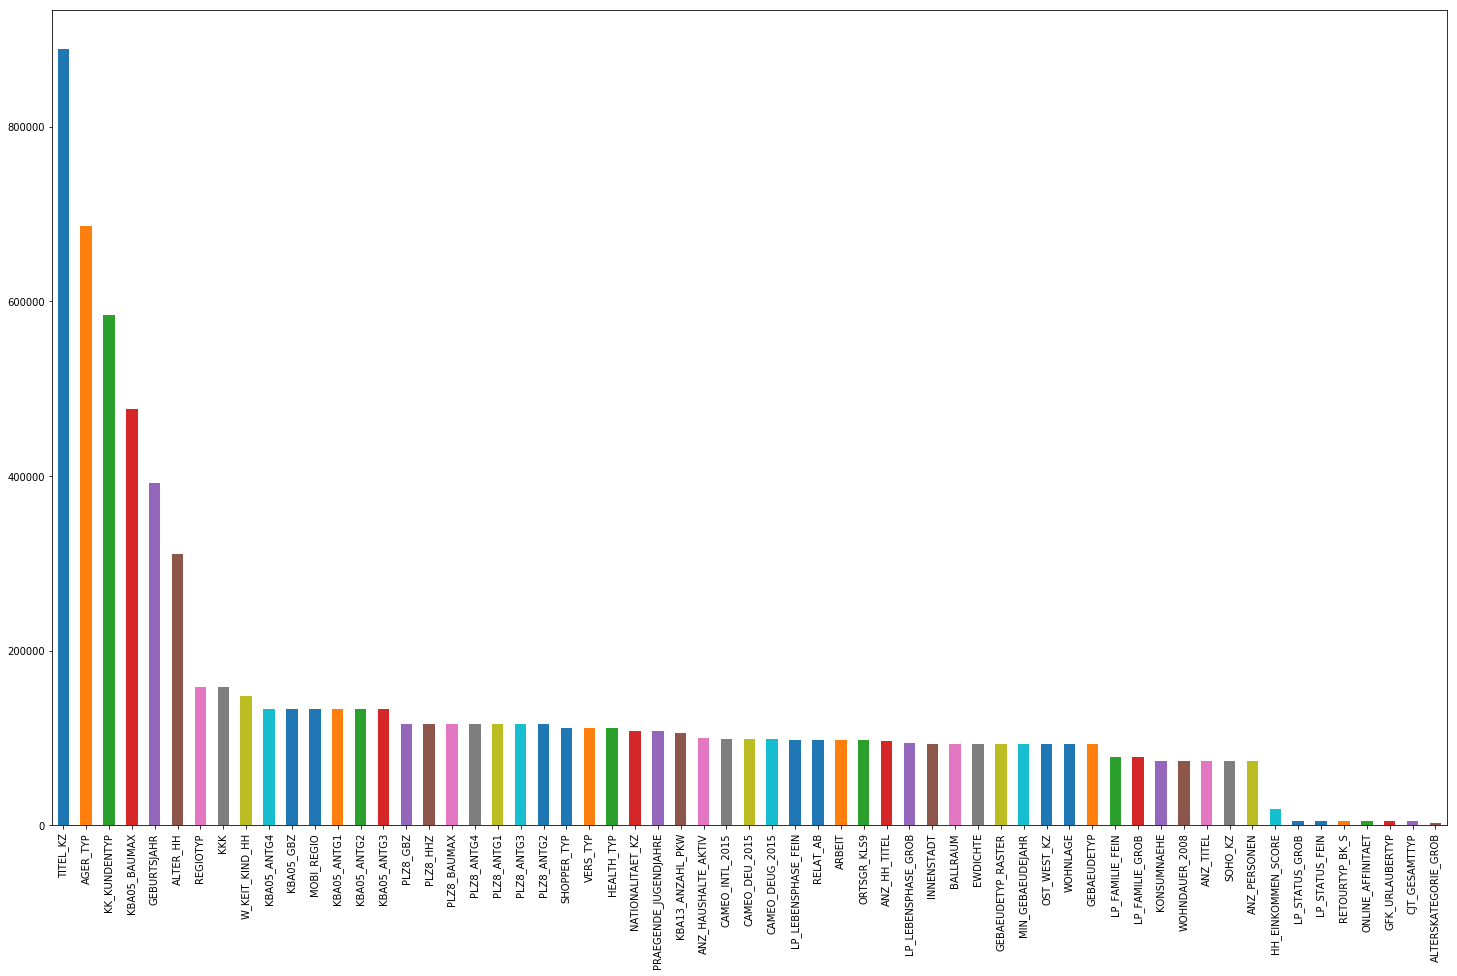

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(25, 15))
missing[missing!=0].sort_values(ascending=False).plot.bar()

In [16]:
#Percentage of missing data - (It is a good idea to understand the percentage of missing data sothat it is easy to remove outliers. 
missing_percentage = missing/azdias.shape[0]*100
missing_percentage[missing_percentage!=0].sort_values(ascending=False).reset_index()

,index,0
0,TITEL_KZ,99.757636
1,AGER_TYP,76.955435
2,KK_KUNDENTYP,65.596749
3,KBA05_BAUMAX,53.468668
4,GEBURTSJAHR,44.020282
5,ALTER_HH,34.813699
6,REGIOTYP,17.735668
7,KKK,17.735668
8,W_KEIT_KIND_HH,16.605084
9,KBA05_ANTG4,14.959701


In [17]:
missing_percentage[missing_percentage!=0].sort_values(ascending=False).reset_index().head(10)

,index,0
0,TITEL_KZ,99.757636
1,AGER_TYP,76.955435
2,KK_KUNDENTYP,65.596749
3,KBA05_BAUMAX,53.468668
4,GEBURTSJAHR,44.020282
5,ALTER_HH,34.813699
6,REGIOTYP,17.735668
7,KKK,17.735668
8,W_KEIT_KIND_HH,16.605084
9,KBA05_ANTG4,14.959701


In the above cell, the percentage of missing data (It is a good idea to understand the percentage). If more than 25% data missing, it is better not to use that feature for analysis. So in this dataset, I am planning to remove 6 columns. 

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
azdias.drop(outliers, axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The columns with most missing data are:
1. TITEL_KZ - Academic title flag - This data is part of Person level feature - 99.75% data missing
2. AGER_TYP - Best-ager typology - This is person level feature - 76.95% data missing
3. KK_KUNDENTYP - Consumer pattern over past 12 months - Household level feature - 65.59% data missing
4. KBA05_BAUMAX - Most common building type within the microcell - Microcell feature - 53% data missing
5. GEBURTSJAHR - Year of birth- Person level feature - 44.02% data missing
6. ALTER_HH - Birthdate of head of household - Household level feature - 34.81% data missing
These are the 6 columns removed from the dataset. More than 25% data missing from the dataset. So it is a good idea not to use these features, because missing data may affect the distribution pattern. Most missing data are of person level features. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
#rows with missing values
missing_rows = azdias.isnull().sum(axis = 1)
missing_rows = missing_rows[missing_rows!=0].sort_values(ascending=False)
missing_rows

732775    49
643174    49
472919    48
604334    47
604314    47
768879    47
604319    47
604322    47
604323    47
275622    47
62901     47
275620    47
604332    47
275617    47
604305    47
275611    47
275610    47
62912     47
604335    47
604338    47
604346    47
604350    47
146293    47
604356    47
62887     47
768892    47
146291    47
348454    47
604091    47
604092    47
          ..
38561      1
768647     1
607245     1
709042     1
507663     1
607271     1
561427     1
235434     1
235435     1
235445     1
607405     1
62924      1
144785     1
91916      1
820005     1
607433     1
709002     1
38612      1
144760     1
561377     1
607469     1
423798     1
423777     1
507723     1
768704     1
736034     1
736038     1
768679     1
736043     1
237075     1
Length: 268012, dtype: int64

In [20]:
# How much data is missing in each row of the dataset?

missing_rows.size #There are 268012 rows with missing data. 

268012

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_subset_1 = missing_rows[missing_rows <=30]
missing_subset_1 = missing_subset_1.sort_values(ascending=True)
missing_subset_1

237075     1
110252     1
110249     1
110232     1
884377     1
292273     1
309312     1
177403     1
308874     1
539502     1
884695     1
308889     1
884661     1
674335     1
110352     1
664958     1
884622     1
110346     1
308975     1
308988     1
664952     1
110302     1
309043     1
674239     1
309051     1
544336     1
664919     1
884646     1
747312     1
2775       1
          ..
590190    27
61733     27
772199    27
842154    27
1044      27
712823    27
318917    27
46811     28
775008    28
858945    28
333297    28
769134    28
138       29
25985     29
808658    29
874989    29
171901    29
657113    29
244327    29
596416    29
698466    29
263997    29
198970    29
183925    29
690471    30
300778    30
523092    30
149588    30
132085    30
810281    30
Length: 174858, dtype: int64

In [22]:
missing_subset_2 = missing_rows[missing_rows > 30]
missing_subset_2 = missing_subset_2.sort_values(ascending=True)
missing_subset_2

712908    31
110086    31
440518    31
425294    32
242232    32
656964    32
544373    32
836334    32
667609    32
276148    32
92587     32
362129    32
136283    32
26626     32
647875    32
126862    32
738392    32
422496    32
642368    32
579331    32
200682    32
620728    32
319467    32
754134    32
137384    32
189811    32
656180    32
695888    32
869544    32
828801    32
          ..
526503    47
839556    47
839529    47
453402    47
527069    47
453376    47
839537    47
183492    47
527051    47
288864    47
183496    47
221224    47
183499    47
318326    47
453260    47
221169    47
27531     47
527002    47
318322    47
318321    47
318320    47
526991    47
27533     47
318281    47
183599    47
183601    47
453262    47
472919    48
643174    49
732775    49
Length: 93154, dtype: int64

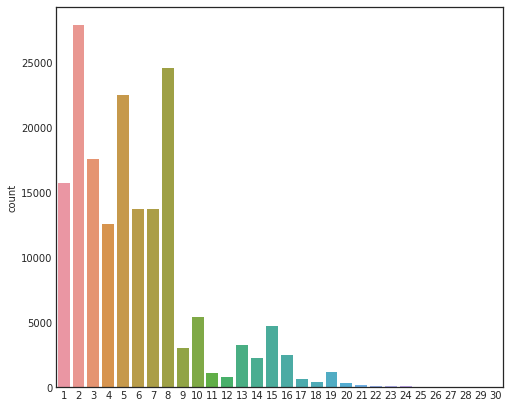

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
import seaborn as sn

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8,7))
sns.countplot(missing_subset_1)
#sns.distplot(missing_subset_1[0])
plt.show()



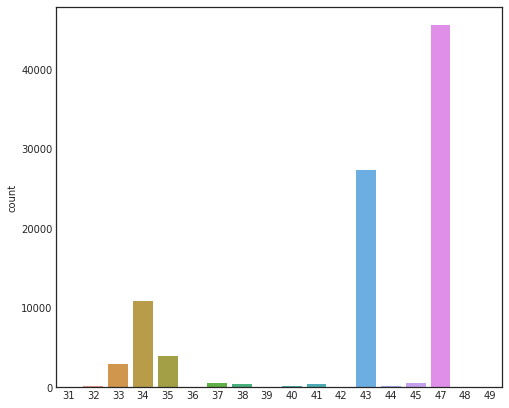

In [24]:
sns.set_style("white")
#sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8,7))
sns.countplot(missing_subset_2)
plt.show()


In [25]:
missing.sort_values(ascending=True).head(5)

ZABEOTYP         0
SEMIO_TRADV      0
SEMIO_PFLICHT    0
SEMIO_KAEM       0
SEMIO_DOM        0
dtype: int64

5 columns with no missing values: 
'ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM'

In [26]:
missing_subset_1.head()

237075    1
110252    1
110249    1
110232    1
884377    1
dtype: int64

In [27]:
missing_subset_2.tail()

183601    47
453262    47
472919    48
643174    49
732775    49
dtype: int64

In [28]:
#got the row numbers with most and least missing values. Create dataframe with most missing values and least missing values. 

#least missing rows and columns
least_missing_rows = [133099, 576385, 807331, 85096, 305913]
least_missing_cols = ['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM']

#most missing rows and columns
most_missing_rows = [643174, 732775, 472919, 891187, 394345]

least = azdias.iloc[least_missing_rows]
most = azdias.iloc[most_missing_rows]

In [29]:
def plotchart(column):
    
    ax1 = plt.subplot(1,2,1)
    sns.countplot(most[column], ax=ax1)
    ax2 = plt.subplot(1,2,2)
    sns.countplot(least[column], ax=ax2)

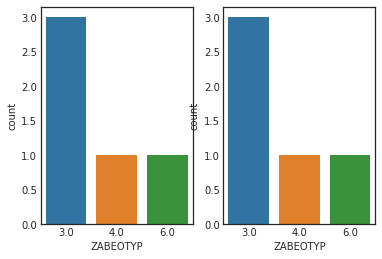

In [30]:
plotchart('ZABEOTYP')

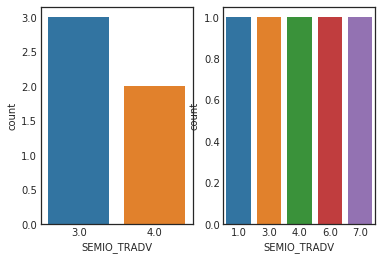

In [31]:
plotchart('SEMIO_TRADV')

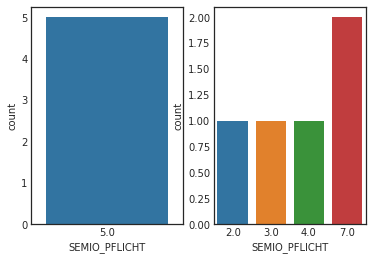

In [32]:
plotchart('SEMIO_PFLICHT')

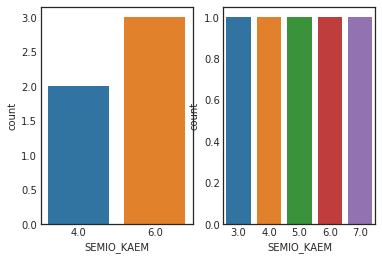

In [33]:
plotchart('SEMIO_KAEM')

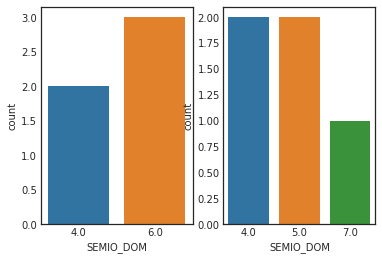

In [34]:
plotchart('SEMIO_DOM')

In [35]:
below_threshold = azdias.drop(azdias[azdias.isnull().sum(axis=1)>25].index)
above_threshold = azdias.drop(azdias[azdias.isnull().sum(axis=1)<=25].index)
below_threshold.isnull().sum()[below_threshold.isnull().sum()==0]
above_threshold.isnull().sum()[above_threshold.isnull().sum()==0]

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

At this point I don't want to delete any row, each row represent a customer. And deleting customer data is not a good idea.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?
print(feat_info['type'].unique())
feat_info

['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [37]:
#To analyze feat_info column value categorial and mixed, we separate them
type_cols = ['categorical', 'mixed']
col_name = feat_info.loc[feat_info['type'].isin(type_cols)]
col_name

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]


In [38]:
#colums with attributes - categorical or mixed
col_name = col_name['attribute'].values
col_name

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX'], dtype=object)

In [39]:
col_name = [col_name for col_name in col_name if col_name in azdias.columns]
col_name

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [40]:
azdias[col_name]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,...,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,PLZ8_BAUMAX
0,1.0,2.0,4.0,10.0,0,15.0,4.0,2.0,2.0,1.0,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,5.0,1.0,10.0,0,21.0,6.0,5.0,3.0,2.0,...,1.0,2.0,5.0,8.0,W,4.0,8,8A,51,1.0
2,2.0,3.0,1.0,10.0,1,3.0,1.0,1.0,1.0,3.0,...,0.0,1.0,5.0,1.0,W,2.0,4,4C,24,1.0
3,2.0,2.0,6.0,1.0,0,NaN,NaN,NaN,NaN,9.0,...,0.0,1.0,3.0,1.0,W,7.0,2,2A,12,1.0
4,1.0,5.0,5.0,5.0,0,32.0,10.0,10.0,5.0,3.0,...,0.0,2.0,4.0,1.0,W,3.0,6,6B,43,2.0
5,2.0,2.0,2.0,1.0,0,8.0,2.0,1.0,1.0,4.0,...,0.0,2.0,4.0,1.0,W,7.0,8,8C,54,1.0
6,2.0,5.0,4.0,12.0,0,2.0,1.0,1.0,1.0,2.0,...,0.0,1.0,4.0,1.0,W,5.0,4,4A,22,1.0
7,1.0,3.0,5.0,9.0,0,5.0,2.0,1.0,1.0,1.0,...,0.0,1.0,1.0,8.0,W,1.0,2,2D,14,1.0
8,1.0,3.0,6.0,3.0,1,10.0,3.0,1.0,1.0,10.0,...,0.0,2.0,6.0,3.0,W,1.0,1,1A,13,1.0
9,2.0,4.0,1.0,12.0,1,4.0,1.0,1.0,1.0,3.0,...,0.0,2.0,4.0,3.0,W,7.0,1,1E,15,1.0


In [41]:
#categorical or mixed values. Now we need to analyze and impute values or drop values based on the information. Before that we can see that in dataframe to get an idea
azdias[col_name]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,...,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,PLZ8_BAUMAX
0,1.0,2.0,4.0,10.0,0,15.0,4.0,2.0,2.0,1.0,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,5.0,1.0,10.0,0,21.0,6.0,5.0,3.0,2.0,...,1.0,2.0,5.0,8.0,W,4.0,8,8A,51,1.0
2,2.0,3.0,1.0,10.0,1,3.0,1.0,1.0,1.0,3.0,...,0.0,1.0,5.0,1.0,W,2.0,4,4C,24,1.0
3,2.0,2.0,6.0,1.0,0,NaN,NaN,NaN,NaN,9.0,...,0.0,1.0,3.0,1.0,W,7.0,2,2A,12,1.0
4,1.0,5.0,5.0,5.0,0,32.0,10.0,10.0,5.0,3.0,...,0.0,2.0,4.0,1.0,W,3.0,6,6B,43,2.0
5,2.0,2.0,2.0,1.0,0,8.0,2.0,1.0,1.0,4.0,...,0.0,2.0,4.0,1.0,W,7.0,8,8C,54,1.0
6,2.0,5.0,4.0,12.0,0,2.0,1.0,1.0,1.0,2.0,...,0.0,1.0,4.0,1.0,W,5.0,4,4A,22,1.0
7,1.0,3.0,5.0,9.0,0,5.0,2.0,1.0,1.0,1.0,...,0.0,1.0,1.0,8.0,W,1.0,2,2D,14,1.0
8,1.0,3.0,6.0,3.0,1,10.0,3.0,1.0,1.0,10.0,...,0.0,2.0,6.0,3.0,W,1.0,1,1A,13,1.0
9,2.0,4.0,1.0,12.0,1,4.0,1.0,1.0,1.0,3.0,...,0.0,2.0,4.0,3.0,W,7.0,1,1E,15,1.0


In [42]:
#How many unique values are there in each columns. This is a vital information. We cannot impute values if the column contains more unique values
azdias[col_name].nunique()

ANREDE_KZ                 2
CJT_GESAMTTYP             6
FINANZTYP                 6
GFK_URLAUBERTYP          12
GREEN_AVANTGARDE          2
LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
LP_FAMILIE_FEIN          11
LP_FAMILIE_GROB           5
LP_STATUS_FEIN           10
LP_STATUS_GROB            5
NATIONALITAET_KZ          3
PRAEGENDE_JUGENDJAHRE    15
SHOPPER_TYP               4
SOHO_KZ                   2
VERS_TYP                  2
ZABEOTYP                  6
GEBAEUDETYP               7
OST_WEST_KZ               2
WOHNLAGE                  8
CAMEO_DEUG_2015           9
CAMEO_DEU_2015           44
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

Now we need to analyse each features. From the above value we can find that there are very few columns which has high unique features. They are
1. GFK_URLAUBERTYP - Vacation habits - This could be an important feature if the product is holiday or travel related. Else we can drop this column safely. (4854 data missing that is .54%)
2. LP_LEBENSPHASE_FEIN - Life stage, fine scale. From further analysis I noticed that these features are available in some other column. So in my opinion we can safely drop that column entirely. (Before droppint the column I need to see how it looks and how many missing values are there) - 97632 values are missing that is nearly 11%
3. LP_LEBENSPHASE_GROB - Life stage, rough scale - We can safely remove this feature, because this data is used in other columns. 94572 values that is 10.61% data missing. 
4. LP_FAMILIE_FEIN - Family type, fine scale - We can drop this column safely because in some other column this particular feature is mentioned. There are 77792 missing values that is 8.73%. 
5. LP_STATUS_FEIN - Social status, fine scale - Safely remove this feature. 4854 data missing that is .54%
6. PRAEGENDE_JUGENDJAHRE - Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) - we can safely remove this feature because 108164 values are missing that is 12.13% data
7. GEBAEUDETYP - Type of building (residential vs. commercial) - 93148 values are missing that is 10.45%. I would safely remove this feature. 
8. WOHNLAGE - Neighborhood quality (or rural flag) - I would drop this feature 
9. CAMEO_DEUG_2015 - German CAMEO: Wealth / Life Stage Typology, rough scale. We can drop this feature because encoding this column will be difficult to manage because of the number of features. 
10. CAMEO_DEU_2015 - German CAMEO: Wealth / Life Stage Typology, detailed scale - drop this feature
11. CAMEO_INTL_2015 - German CAMEO: Wealth / Life Stage Typology, mapped to international code - Drop this feature. 

Other features with unique values more than 2 and less than 7 - 
1. CJT_GESAMTTYP - Customer-Journey-Typology: preferred information and buying channels for consumer
2. FINANZTYP - Most descriptive financial type for individual - I think I can drop this column because the same details are in other columns like FINANZ_MINIMALIST, FINANZ_SPARER etc. 
3. LP_FAMILIE_GROB - Family type, rough scale - I would drop this feature
4. LP_STATUS_GROB - Social status, rough scale - This is an important feature but other features have similar information. So we can drop this column. 
5. NATIONALITAET_KZ- Nationality based on given name analysis - I would drop this column. 
6. SHOPPER_TYP - Shopper typology - I would drop this column as well. 
7. ZABEOTYP - Energy consumption typology - Drop this column
8. PLZ8_BAUMAX - Most common building type within the PLZ8 region - I would drop this column. 


CJT_GESAMTTYP - I am not sure about this feature. In my opinion this is a very important feature and I would like to keep that in my dataset. Only one concern is that this has 7 unique features, that means when I impute values there will be additional 6 more columns in the dataframe. But I still would like to keep that column. 

In [43]:
'''cols_to_impute = ['CJT_GESAMTTYP ',  'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ' ]
cols_to_drop =['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',\
            'LP_STATUS_FEIN', 'LP_STATUS_GROB',  'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', \
            'WOHNLAGE',  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'PLZ8_BAUMAX']
azdias.shape'''

"cols_to_impute = ['CJT_GESAMTTYP ',  'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ' ]\ncols_to_drop =['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',            'LP_STATUS_FEIN', 'LP_STATUS_GROB',  'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP',             'WOHNLAGE',  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'PLZ8_BAUMAX']\nazdias.shape"

In [44]:
'''azdias.drop(cols_to_drop, axis=1, inplace=True)'''

'azdias.drop(cols_to_drop, axis=1, inplace=True)'

In [45]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [46]:
azdias.shape

(891221, 79)


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [47]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

This is the list of Categorical featues to encode. Most of the variables are binary except CJT_GESAMTTYP. There are 7 variables in this. So we can use OneHotEncoding for this variable. 
* CJT_GESAMTTYP - Multi-level. Use OneHotEncoding
* ANREDE_KZ - Binary
* GREEN_AVANTGARDE - Binary
* SOHO_KZ - Binary
* VERS_TYP - Binary
* OST_WEST_KZ - Binary

We need to encode these variables, but before re-encoding, we have to impute values to the NaN values. 

In [48]:
# Re-encode categorical variable(s) to be kept in the analysis.

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

(Details are in the above cells)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

This field represent - Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)  - We can categorize that into two.
1. Decade Variable [PRAEGENDE_JUGENDJAHRE_DECADE]- This is an  interval variable represent the decade, the first decade(40's) will be 1, second (50's) will be 2, so on. The values ranges from 0 to 5. 
2. Movement Variable [PRAEGENDE_JUGENDJAHRE_MOVEMENT] - that has values 
Mainstream, E+W - 1
Avantgarde, E+W - 2
Mainstream, E - 3
Avantgarde, E - 4
Mainstream, W - 5
Avantgarde, W - 6
reference Udacity discussion - https://knowledge.udacity.com/questions/115912

 1: 40s - war years (Mainstream, E+W)
 2: 40s - reconstruction years (Avantgarde, E+W)
 3: 50s - economic miracle (Mainstream, E+W)
 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
 5: 60s - economic miracle (Mainstream, E+W)
 6: 60s - generation 68 / student protestors (Avantgarde, W)
 7: 60s - opponents to the building of the Wall (Avantgarde, E)
 8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)

In [49]:
#PRAEGENDE_JUGENDJAHRE variables encoding

decade= {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)

movement = {1:1, 2: 2, 3: 1, 4:2, 5:1, 6:3, 7: 4, 8:1, 9:2, 10:5, 11:3, 12:6, 13: 4, 14:1, 15:2 }
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)


In [50]:
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isnull().sum()

108164

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
We can create 2 columns - one based on wealth and another on lifestage. So the 2 columns can be named as CAMEO_INTL_Wealth the values range from 1-5 and another column CAMEO_INTL_Lifestage with values 1 -5. 



In [51]:
Wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

azdias['CAMEO_INTL_Wealth'] = azdias['CAMEO_INTL_2015']
azdias['CAMEO_INTL_Wealth'].replace(Wealth, inplace=True)

azdias['CAMEO_INTL_Lifestage'] = azdias['CAMEO_INTL_2015']
Lifestage = { '11': 1, '21': 1, '31':1, '41':1, '51':1, '12': 2, '22':2, '32': 2, '42': 2, '52':2,
             '13': 3, '23': 3, '33':3, '43':3, '53':3, '14': 4, '24': 4, '34': 4, '44': 4, '54': 4, '15': 5, '25': 5, '35': 5, '45': 5, '55': 5}
azdias['CAMEO_INTL_Lifestage'].replace(Lifestage, inplace=True)


In [52]:
azdias['CAMEO_INTL_Lifestage'].isnull().sum()

99352

In [53]:
azdias.shape

(891221, 83)

In [54]:
cols_to_impute = ['CJT_GESAMTTYP',  'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
cols_to_drop =['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',\
            'LP_STATUS_FEIN', 'LP_STATUS_GROB',  'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', \
            'WOHNLAGE',  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'PLZ8_BAUMAX', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']
azdias.shape

(891221, 83)

In [55]:
azdias.drop(cols_to_drop, axis=1, inplace=True)

In [56]:
print(type(azdias))
azdias.head()

<class 'pandas.core.frame.DataFrame'>


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_Wealth,CAMEO_INTL_Lifestage
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


In [57]:
#azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)
#azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
azdias.shape

(891221, 65)

 * LP_LEBENSPHASE_FEIN - Life stage, fine scale. From further analysis I noticed that these features are available in the column  derive from CAMEO_INTL_2015. So in my opinion we can safely drop that column entirely. 
 
* LP_LEBENSPHASE_GROB - Life stage, rough scale - We can safely remove this feature, because this data is available in the column derived from CAMEO_INTL_2015. 
* WOHNLAGE - Neighborhood quality (or rural flag) - I would drop this feature
* PLZ8_BAUMAX - Most common building type within the PLZ8 region - I would drop this column.

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
'''cus = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
cus.shape'''

"cus = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')\ncus.shape"

In [61]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_or_unknown[0] != '':
            for value in missing_or_unknown:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    df.loc[df[attribute] == int(value), attribute] = np.nan
                else:
                     df.loc[df[attribute] == value, attribute] = np.nan

    # remove selected columns and rows, ...
    outliers = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(outliers, axis=1, inplace=True)
    
     # select, re-encode, and engineer column values.
    #To analyze feat_info column value categorial and mixed, we separate them
    type_cols = ['categorical', 'mixed']
    col_name = feat_info.loc[feat_info['type'].isin(type_cols)]
    col_name = col_name['attribute'].values
    col_name = [col_name for col_name in col_name if col_name in df.columns]
    
    #PRAEGENDE_JUGENDJAHRE variables encoding
    decade= {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
    movement = {1:1, 2: 2, 3: 1, 4:2, 5:1, 6:3, 7: 4, 8:1, 9:2, 10:5, 11:3, 12:6, 13: 4, 14:1, 15:2 }
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)
    
     #CAMEO_INTL_2015 variables encoding
    Wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
    df['CAMEO_INTL_Wealth'] = df['CAMEO_INTL_2015']
    df['CAMEO_INTL_Wealth'].replace(Wealth, inplace=True)
    df['CAMEO_INTL_Lifestage'] = df['CAMEO_INTL_2015']
    Lifestage = { '11': 1, '21': 1, '31':1, '41':1, '51':1, '12': 2, '22':2, '32': 2, '42': 2, '52':2,
             '13': 3, '23': 3, '33':3, '43':3, '53':3, '14': 4, '24': 4, '34': 4, '44': 4, '54': 4, '15': 5, '25': 5, '35': 5, '45': 5, '55': 5}
    df['CAMEO_INTL_Lifestage'].replace(Lifestage, inplace=True)
    
    df.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

    cols_to_impute = ['CJT_GESAMTTYP',  'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
    cols_to_drop =['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',\
            'LP_STATUS_FEIN', 'LP_STATUS_GROB',  'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', \
            'WOHNLAGE',  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'PLZ8_BAUMAX', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    
    # Return the cleaned dataframe.
    return df
#clean_data(cus)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [67]:
#Now we need to impute the values for the categorical values
#first of all we need to OST_WEST_KZ change the values to numeric
azdias.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

In [70]:
from sklearn.preprocessing import Imputer
#We can use sklearn simpleimputer to impute missing values. We can use the most frequent value(mode) to replace nan values
imputer = Imputer(missing_values=np.nan, strategy='most_frequent')
azdias_arr = imputer.fit_transform(azdias)

In [71]:
print(azdias_arr.shape)
azdias_arr

(891221, 65)


array([[ 2.,  1.,  2., ...,  1.,  5.,  1.],
       [ 1.,  2.,  5., ...,  1.,  5.,  1.],
       [ 3.,  2.,  3., ...,  2.,  2.,  4.],
       ..., 
       [ 2.,  2.,  4., ...,  1.,  2.,  4.],
       [ 1.,  1.,  3., ...,  1.,  5.,  1.],
       [ 4.,  1.,  1., ...,  1.,  4.,  3.]])

In [72]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_Wealth,CAMEO_INTL_Lifestage
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


In [73]:
azdias_df = pd.DataFrame(azdias_arr, columns=azdias.columns, index=azdias.index)
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_Wealth,CAMEO_INTL_Lifestage
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,...,0.0,3.0,3.0,4.0,5.0,3.0,6.0,1.0,5.0,1.0
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


In [74]:
azdias_df.isnull().sum()

ALTERSKATEGORIE_GROB              0
ANREDE_KZ                         0
CJT_GESAMTTYP                     0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
GREEN_AVANTGARDE                  0
HEALTH_TYP                        0
RETOURTYP_BK_S                    0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT                     0
SEMIO_TRADV                       0
SOHO_KZ                           0
VERS_TYP                    

In [75]:
cols_to_impute

azdias_df[cols_to_impute]

,CJT_GESAMTTYP,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP
0,2.0,1.0,0.0,0.0,2.0
1,5.0,2.0,0.0,1.0,2.0
2,3.0,2.0,1.0,0.0,1.0
3,2.0,2.0,0.0,0.0,1.0
4,5.0,1.0,0.0,0.0,2.0
5,2.0,2.0,0.0,0.0,2.0
6,5.0,2.0,0.0,0.0,1.0
7,3.0,1.0,0.0,0.0,1.0
8,3.0,1.0,1.0,0.0,2.0
9,4.0,2.0,1.0,0.0,2.0


In [76]:
from sklearn.preprocessing import OneHotEncoder
ohencoder = OneHotEncoder(handle_unknown='ignore')
print(azdias_df.shape)
#oh_df = ohencoder.fit_transform(azdias_modified[cols_to_impute])
azdias = pd.get_dummies(azdias_df, columns=cols_to_impute, drop_first=True)

azdias.head()

(891221, 65)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_INTL_Lifestage,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,ANREDE_KZ_2.0,GREEN_AVANTGARDE_1.0,SOHO_KZ_1.0,VERS_TYP_2.0
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,3.0,5.0,2.0,...,1.0,1,0,0,0,0,0,0,0,1
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,1.0,0,0,0,1,0,1,0,1,1
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,4.0,0,1,0,0,0,1,1,0,0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,2.0,1,0,0,0,0,1,0,0,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,3.0,0,0,0,1,0,0,0,0,1


In [ ]:
'''col_drop = [ 'CJT_GESAMTTYP_6.0', 'ANREDE_KZ_2.0', 'GREEN_AVANTGARDE_1',  'SOHO_KZ_1.0',  'VERS_TYP_2.0']
azdias.drop(col_drop, axis=1, inplace=True)'''


In [77]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
azdias_arr = scalar.fit_transform(azdias)
azdias_scaled = pd.DataFrame(azdias_arr, columns=azdias.columns)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_INTL_Lifestage,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,ANREDE_KZ_2.0,GREEN_AVANTGARDE_1.0,SOHO_KZ_1.0,VERS_TYP_2.0
0,-0.751680,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.938197,1.107928,-0.999639,...,-1.095866,2.233739,-0.461435,-0.565277,-0.389460,-0.456895,-1.045218,-0.494701,-0.088255,0.864739
1,-1.743339,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,0.938197,-1.711653,0.541539,...,-1.095866,-0.447680,-0.461435,-0.565277,2.567659,-0.456895,0.956738,-0.494701,11.330820,0.864739
2,0.239980,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,0.938197,-0.301862,0.027813,...,0.879581,-0.447680,2.167155,-0.565277,-0.389460,-0.456895,0.956738,2.021423,-0.088255,-1.156419
3,1.231640,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.385397,-1.006758,0.541539,...,-0.437384,2.233739,-0.461435,-0.565277,-0.389460,-0.456895,0.956738,-0.494701,-0.088255,-1.156419
4,0.239980,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,0.938197,1.107928,1.055265,...,0.221098,-0.447680,-0.461435,-0.565277,2.567659,-0.456895,-1.045218,-0.494701,-0.088255,0.864739


In [78]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_scaled.isnull().sum()                   

ALTERSKATEGORIE_GROB              0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
HEALTH_TYP                        0
RETOURTYP_BK_S                    0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT                     0
SEMIO_TRADV                       0
ANZ_PERSONEN                      0
ANZ_TITEL                         0
HH_EINKOMMEN_SCORE                0
W_KEIT_KIND_HH                    0
WOHNDAUER_2008              

In [ ]:
# Apply feature scaling to the general population demographics data.


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [79]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

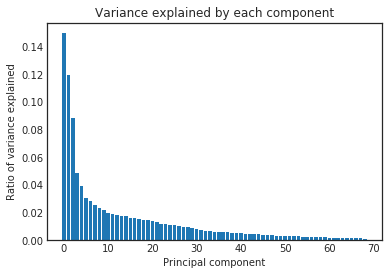

In [80]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

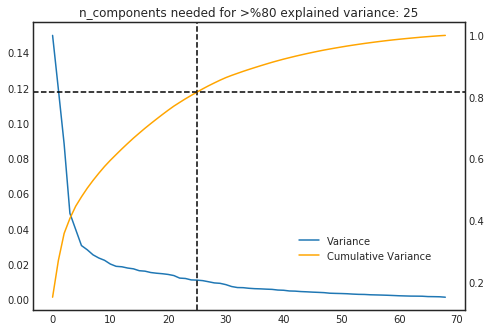

In [81]:
# Investigate the variance accounted for by each principal component.
from sklearn.metrics import explained_variance_score

#plt.plot(np.cumsum(pca.explained_variance_ratio_))


n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.80)[0]+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.60,0.2));

In [82]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA()
pca = PCA(n_components=n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

 80% accuracy with 24 features. 

In [83]:
#Percentage of variance explained by each of the selected components. 
pca.explained_variance_ratio_

array([ 0.1496928 ,  0.11916148,  0.08806849,  0.04871572,  0.03956473,
        0.03044182,  0.02805966,  0.02519292,  0.02338966,  0.02207096,
        0.01996454,  0.01866505,  0.01840519,  0.01769113,  0.01724333,
        0.01617995,  0.01591678,  0.01514389,  0.01475086,  0.01446147,
        0.01404166,  0.01341861,  0.01197993,  0.01175338,  0.01093384])

In [84]:
#The amount of variance explained by each of the selected components. Equal to n_components largest eigenvalues of the covariance matrix of X.
pca.explained_variance_

array([ 10.32881496,   8.22215109,   6.07673257,   3.3613886 ,
         2.72996952,   2.10048826,   1.93611864,   1.73831323,
         1.61388817,   1.52289772,   1.37755489,   1.28789   ,
         1.26995921,   1.22068917,   1.18979081,   1.11641776,
         1.09825912,   1.04492963,   1.0178102 ,   0.99784236,
         0.96887552,   0.92588531,   0.82661638,   0.81098397,   0.75443614])

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

12 principal components for 60% accuracy. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [85]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

'''pca_components = pd.DataFrame(pca.components_)
pca_components.columns = azdias_scaled.columns
pca_components[:10]
'''
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [86]:
pca_weight_0 = pca_weights(pca, 0)
pca_weight_0 = pd.DataFrame(pca_weight_0)


In [87]:
pca_0_p = pca_weight_0.where(pca_weight_0 > 0)
pca_0_p = pca_0_p.dropna().transpose()
pca_0_p

,PLZ8_ANTG3,CAMEO_INTL_Wealth,EWDICHTE,FINANZ_SPARER,ORTSGR_KLS9,PLZ8_ANTG4,SEMIO_REL,PRAEGENDE_JUGENDJAHRE_DECADE,SEMIO_PFLICHT,PLZ8_ANTG2,...,W_KEIT_KIND_HH,SEMIO_KRIT,OST_WEST_KZ,PLZ8_HHZ,ANZ_HH_TITEL,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_3.0,SEMIO_SOZ,ANREDE_KZ_2.0,CJT_GESAMTTYP_5.0
0,0.214337,0.200443,0.195126,0.194951,0.177241,0.164492,0.161568,0.161414,0.157332,0.14698,...,0.039117,0.034041,0.030109,0.026506,0.024893,0.023027,0.022007,0.013922,0.013432,0.009745


In [88]:
pca_0_n = pca_weight_0.where(pca_weight_0 < 0)
pca_0_n = pca_0_n.dropna().transpose()
pca_0_n

,SOHO_KZ_1.0,KBA13_ANZAHL_PKW,ANZ_TITEL,KBA05_ANTG2,PRAEGENDE_JUGENDJAHRE_MOVEMENT,ONLINE_AFFINITAET,MIN_GEBAEUDEJAHR,RETOURTYP_BK_S,WOHNDAUER_2008,SEMIO_VERT,...,INNENSTADT,PLZ8_GBZ,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB,KONSUMNAEHE,KBA05_GBZ,KBA05_ANTG1,PLZ8_ANTG1,MOBI_REGIO,FINANZ_MINIMALIST
0,-0.004073,-0.004735,-0.005934,-0.011786,-0.015045,-0.018989,-0.042579,-0.048901,-0.052676,-0.076596,...,-0.144805,-0.154906,-0.155178,-0.16121,-0.171147,-0.197935,-0.210071,-0.210734,-0.219725,-0.22541


In [89]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_1 = pca_weights(pca, 1)
pca_weight_1 = pd.DataFrame(pca_weight_1)

In [90]:
pca_1_p = pca_weight_1.where(pca_weight_1 > 0)
pca_1_p = pca_1_p.dropna().transpose()
pca_1_p

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,SEMIO_ERL,RETOURTYP_BK_S,SEMIO_LUST,FINANZ_HAUSBAUER,PLZ8_ANTG4,ORTSGR_KLS9,PLZ8_ANTG3,EWDICHTE,...,SEMIO_DOM,ANZ_HH_TITEL,WOHNDAUER_2008,PLZ8_HHZ,VERS_TYP_2.0,FINANZ_MINIMALIST,KBA05_ANTG2,REGIOTYP,ANZ_TITEL,KKK
1,0.230751,0.212535,0.202893,0.161524,0.161061,0.153487,0.150034,0.141188,0.140304,0.114794,...,0.045367,0.042545,0.039292,0.03306,0.023697,0.023683,0.01392,0.009411,0.007944,0.001605


In [91]:
pca_1_n = pca_weight_1.where(pca_weight_1 < 0)
pca_1_n = pca_1_n.dropna().transpose()
pca_1_n

,SOHO_KZ_1.0,CAMEO_INTL_Lifestage,CJT_GESAMTTYP_3.0,GREEN_AVANTGARDE_1.0,CJT_GESAMTTYP_5.0,SEMIO_VERT,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_6.0,MIN_GEBAEUDEJAHR,...,SEMIO_RAT,ONLINE_AFFINITAET,SEMIO_KULT,FINANZ_ANLEGER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,SEMIO_REL,PRAEGENDE_JUGENDJAHRE_DECADE
1,-0.000833,-0.007003,-0.025055,-0.026469,-0.029031,-0.029875,-0.044743,-0.051034,-0.052907,-0.055046,...,-0.159821,-0.171192,-0.175417,-0.199949,-0.204861,-0.20771,-0.210136,-0.210514,-0.219499,-0.224177


In [92]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
                                    
pca_weight_2 = pca_weights(pca, 2)
pca_weight_2 = pd.DataFrame(pca_weight_2)

In [93]:
pca_2_p = pca_weight_2.where(pca_weight_2 > 0)
pca_2_p = pca_2_p.dropna().transpose()
pca_2_p

,SEMIO_VERT,SEMIO_SOZ,SEMIO_KULT,SEMIO_FAM,PLZ8_ANTG4,FINANZ_MINIMALIST,SEMIO_MAT,HH_EINKOMMEN_SCORE,ORTSGR_KLS9,RETOURTYP_BK_S,...,ANZ_PERSONEN,ALTERSKATEGORIE_GROB,ARBEIT,ANZ_TITEL,EWDICHTE,W_KEIT_KIND_HH,SEMIO_TRADV,MOBI_REGIO,KONSUMNAEHE,SOHO_KZ_1.0
2,0.3476,0.297344,0.286589,0.220554,0.108427,0.086441,0.072466,0.071958,0.070941,0.069626,...,0.022651,0.02022,0.011153,0.009966,0.008141,0.008099,0.00765,0.00736,0.006211,0.004952


In [94]:
pca_2_n = pca_weight_2.where(pca_weight_2 < 0)
pca_2_n = pca_2_n.dropna().transpose()
pca_2_n

,KBA05_ANTG1,MIN_GEBAEUDEJAHR,SEMIO_LUST,CAMEO_INTL_Wealth,ONLINE_AFFINITAET,WOHNDAUER_2008,FINANZ_HAUSBAUER,CJT_GESAMTTYP_2.0,KKK,SEMIO_PFLICHT,...,CJT_GESAMTTYP_6.0,FINANZ_UNAUFFAELLIGER,KBA13_ANZAHL_PKW,SEMIO_RAT,FINANZ_ANLEGER,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,ANREDE_KZ_2.0,SEMIO_KAEM
2,-0.000219,-0.004369,-0.004734,-0.005432,-0.008984,-0.018619,-0.019521,-0.020788,-0.023834,-0.02948,...,-0.093497,-0.102576,-0.109465,-0.149674,-0.170676,-0.172379,-0.311057,-0.31749,-0.335656,-0.342832




### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [96]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...    
# compute the average within-cluster distances.
    
from sklearn.cluster import KMeans
n_counts = range(2, 20)
score = []
for n in n_counts:
    k_model = KMeans(n_clusters=n, random_state=0)
    k_model.fit(azdias_pca)
#    print(k_model.score(azdias_pca))
    score.append(k_model.score(azdias_pca))
       
score = np.abs(score)
score

array([ 42743078.3777437 ,  38830219.4713674 ,  36235703.63113325,
        34234198.54314651,  32768392.63739821,  31447842.30243108,
        30300636.64688903,  29438434.99796766,  28691449.59801924,
        28060637.53761448,  27650553.60586756,  27617262.8307829 ,
        26843893.40127266,  26523981.65412458,  26191164.24359835,
        25767833.36275462,  25204392.22852134,  24765648.77849096])

Text(0,0.5,'Distance to centroid')

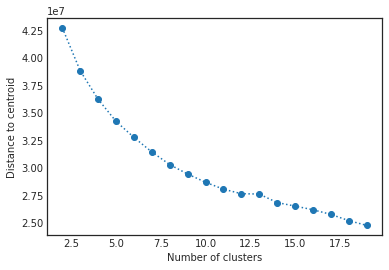

In [97]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_counts, score, ':o')
plt.xlabel("Number of clusters")
plt.ylabel("Distance to centroid")


In [98]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean = KMeans(n_clusters=6, random_state=1)
azdias_k = kmean.fit_predict(azdias_pca)
azdias_k

array([3, 0, 1, ..., 0, 2, 5], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

It looks like there are nearly 6 clusters(in between 5 and 7). We can find the number of clusters with elbow plot, the distance between the centroids rapidly decrease up to 6, then it slow down. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [99]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [100]:
#Apply preprocessing to customer data
customers =clean_data(customers)
cols = customers.columns
index = customers.index
customers['OST_WEST_KZ']

0         0.0
1         NaN
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        NaN
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
         ... 
191622    0.0
191623    0.0
191624    0.0
191625    0.0
191626    0.0
191627    0.0
191628    0.0
191629    0.0
191630    0.0
191631    0.0
191632    0.0
191633    0.0
191634    0.0
191635    0.0
191636    0.0
191637    0.0
191638    0.0
191639    0.0
191640    0.0
191641    0.0
191642    1.0
191643    0.0
191644    0.0
191645    0.0
191646    0.0
191647    0.0
191648    0.0
191649    0.0
191650    0.0
191651    0.0
Name: OST_WEST_KZ, Length: 191652, dtype: float64

In [101]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer = imputer.fit_transform(customers)
customers = pd.DataFrame(customer, columns=cols, index=index)
#Now we need to impute the values for the categorical values and drop one column
customers = pd.get_dummies(customers, columns=cols_to_impute, drop_first=True)
customer = scalar.transform(customers)
customers_scaled = pd.DataFrame(customer, columns=customers.columns)
customers_scaled.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_INTL_Lifestage,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,ANREDE_KZ_2.0,GREEN_AVANTGARDE_1.0,SOHO_KZ_1.0,VERS_TYP_2.0
0,1.23164,1.457527,-1.243244,1.209329,-1.329319,-0.587980,-0.794475,-1.708990,1.107928,1.055265,...,0.221098,-0.447680,-0.461435,-0.565277,2.567659,-0.456895,-1.045218,2.021423,-0.088255,-1.156419
1,1.23164,1.457527,-1.243244,1.209329,-1.329319,0.084637,-0.794475,-1.708990,-0.301862,-0.485913,...,0.879581,-0.447680,-0.461435,-0.565277,-0.389460,2.188686,-1.045218,-0.494701,-0.088255,-1.156419
2,1.23164,1.457527,-1.243244,1.209329,-1.329319,0.757254,0.683452,-0.385397,1.107928,-0.999639,...,0.879581,2.233739,-0.461435,-0.565277,-0.389460,-0.456895,0.956738,2.021423,-0.088255,0.864739
3,1.23164,1.457527,-1.243244,1.209329,-0.675554,-1.260597,-0.794475,-0.385397,-0.301862,1.055265,...,0.879581,2.233739,-0.461435,-0.565277,-0.389460,-0.456895,-1.045218,-0.494701,-0.088255,-1.156419
4,0.23998,-0.056416,-1.243244,0.452976,0.631976,1.429871,-0.794475,0.938197,1.107928,0.027813,...,-1.095866,-0.447680,-0.461435,-0.565277,-0.389460,2.188686,-1.045218,-0.494701,-0.088255,0.864739


In [102]:
#pca - 25components
customer_pca = pca.transform(customers_scaled)
#clustering - find 6 clusters
customer_k = kmean.predict(customer_pca)
customer_k

array([5, 5, 1, ..., 5, 1, 5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

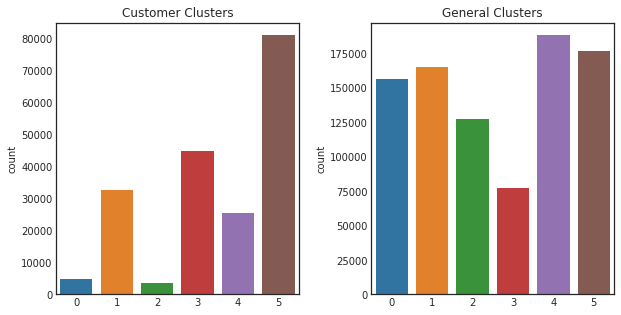

In [103]:
    # Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customer_k, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_k, ax=axs[1])
axs[1].set_title('General Clusters')


In [104]:

customer_cluster = {x:sum(customer_k == x)/len(customer_k) for x in range(6)}
azdias_cluster = {x:sum(azdias_k == x)/len(azdias_k) for x in range(6)}

cluster_df = pd.DataFrame({'cluster': list(azdias_cluster.keys()), 
                          'general': list(azdias_cluster.values()),
                          'customer': list(customer_cluster.values())})
cluster_df

,cluster,general,customer
0,0,0.175623,0.024607
1,1,0.184871,0.169375
2,2,0.143225,0.017667
3,3,0.086974,0.233778
4,4,0.210894,0.132944
5,5,0.198413,0.421629


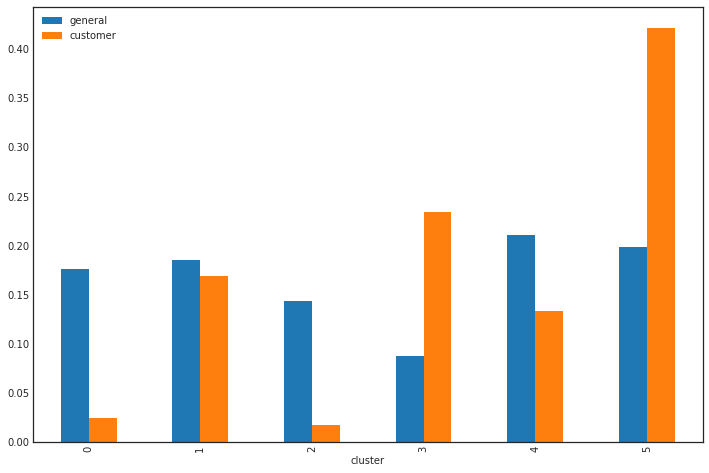

In [105]:
cluster_df.plot(x='cluster', y = ['general', 'customer'], kind='bar', figsize=(12,8))


In [107]:
data = scalar.inverse_transform(pca.inverse_transform(customer_pca[np.where(customer_k == 5)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=azdias_scaled.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df.head().transpose())

                                     0       1       2       3       4
ALTERSKATEGORIE_GROB               4.0     4.0     3.0     3.0     3.0
FINANZ_MINIMALIST                  5.0     5.0     5.0     5.0     6.0
FINANZ_SPARER                      1.0     1.0     1.0     1.0     0.0
FINANZ_VORSORGER                   5.0     5.0     5.0     5.0     5.0
FINANZ_ANLEGER                     0.0     1.0     2.0     1.0     1.0
FINANZ_UNAUFFAELLIGER              2.0     2.0     1.0     2.0     1.0
FINANZ_HAUSBAUER                   2.0     2.0     3.0     2.0     2.0
HEALTH_TYP                         1.0     1.0     2.0     3.0     2.0
RETOURTYP_BK_S                     4.0     3.0     4.0     4.0     4.0
SEMIO_SOZ                          6.0     4.0     5.0     6.0     5.0
SEMIO_FAM                          5.0     5.0     5.0     5.0     4.0
SEMIO_REL                          3.0     4.0     4.0     3.0     3.0
SEMIO_MAT                          5.0     5.0     4.0     2.0     3.0
SEMIO_

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Cluster 5
Overrepresented is the cluster with people older than 46 years old with higher house hold income. 

In [108]:
data = scalar.inverse_transform(pca.inverse_transform(customer_pca[np.where(customer_k == 0)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=azdias_scaled.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df.head().transpose())

                                     0       1       2       3       4
ALTERSKATEGORIE_GROB               3.0     2.0     1.0     2.0     3.0
FINANZ_MINIMALIST                  3.0     2.0     3.0     3.0     1.0
FINANZ_SPARER                      3.0     3.0     4.0     3.0     5.0
FINANZ_VORSORGER                   3.0     3.0     3.0     3.0     2.0
FINANZ_ANLEGER                     4.0     2.0     4.0     5.0     5.0
FINANZ_UNAUFFAELLIGER              4.0     2.0     4.0     5.0     4.0
FINANZ_HAUSBAUER                   3.0     2.0     2.0     3.0     4.0
HEALTH_TYP                         2.0     2.0     3.0     2.0     1.0
RETOURTYP_BK_S                     4.0     3.0     2.0     2.0     2.0
SEMIO_SOZ                          3.0     4.0     3.0     3.0     2.0
SEMIO_FAM                          4.0     3.0     4.0     4.0     3.0
SEMIO_REL                          6.0     3.0     6.0     6.0     3.0
SEMIO_MAT                          5.0     5.0     4.0     4.0     4.0
SEMIO_

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

Cluster - 0
 Underrepresented cluster has young population with age below 46 years. Most of them are pre family couples, singles or young couple with children and they belongs to poorer households. 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
!!jupyter nbconvert *.ipynb